In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/scan_dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


In [3]:
#import matplotlib.pyplot as plt
#import networkx as nx 
#import numpy as np 
#G = graph #

#node_colours= []
#node_sizes = []
#for node in list(G.nodes):
#    if isinstance(node,int):
#        node_colours.append('black')
#        node_sizes.append(0)
#    else:
#        node_colours.append('white')
#        node_sizes.append(100)#

#edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
#vmin = np.min(weights)
#vmax = np.max(weights)
#cmap = plt.cm.viridis#

#nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,#edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)

production run

In [4]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)
t.rank_by_number_of_atoms = True

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats

1 H2O + 1 SO2 = 1 H2SO3           39
1 H2 + 1 SO2 = 1 O2 + 1 H2S       33
3 H2 + 1 SO2 = 2 H2O + 1 H2S      24
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4     13
3 O2 + 2 H2S = 2 H2O + 2 SO2      13
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2     9
2 H2 + 1 O2 = 2 H2O                8
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4     8
2 H2 + 2 SO2 = 1 H2SO4 + 1 H2S     4
2 O2 + 1 H2S = 1 H2SO4             4
3 H2 + 1 H2SO3 = 3 H2O + 1 H2S     1
dtype: int64

In [ ]:
g = analysis.result_to_pyvis(data)


{'H2SO3': {'color': '#97c2fc',
  'size': 10,
  'id': 'H2SO3',
  'label': 'H2SO3',
  'shape': 'box',
  'font': {'color': 'white'}},
 '0': {'color': '#67000d',
  'size': 8,
  'id': '0',
  'label': None,
  'shape': 'circle',
  'font': {'color': 'white'},
  'title': '1 H2O + 1 SO2 = 1 H2SO3'},
 '10': {'color': '#97c2fc',
  'size': 8,
  'id': '10',
  'label': None,
  'shape': 'circle',
  'font': {'color': 'white'},
  'title': '3 H2 + 1 H2SO3 = 3 H2O + 1 H2S'},
 'H2O': {'color': '#97c2fc',
  'size': 10,
  'id': 'H2O',
  'label': 'H2O',
  'shape': 'box',
  'font': {'color': 'white'}},
 'SO2': {'color': '#97c2fc',
  'size': 10,
  'id': 'SO2',
  'label': 'SO2',
  'shape': 'box',
  'font': {'color': 'white'}},
 '6': {'color': '#fee2d5',
  'size': 8,
  'id': '6',
  'label': None,
  'shape': 'circle',
  'font': {'color': 'white'},
  'title': '1 O2 + 2 H2O + 2 SO2 = 2 H2SO4'},
 '2': {'color': '#f44f39',
  'size': 8,
  'id': '2',
  'label': None,
  'shape': 'circle',
  'font': {'color': 'white'},
  

In [49]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data.round(2)

,initial,mean,diff,std,var
H2S,10.0,2.27,-7.73,3.82,14.59
O2,10.0,2.53,-7.47,5.11,26.15
H2SO3,0.0,0.00,0.00,0.00,0.00
S8,0.0,0.22,0.22,0.51,0.26
H2SO4,0.0,0.64,0.64,2.38,5.64
H2O,30.0,31.65,1.65,9.31,86.58
H2,0.0,2.75,2.75,4.48,20.06
SO2,10.0,14.10,4.10,6.14,37.64


<Axes: >

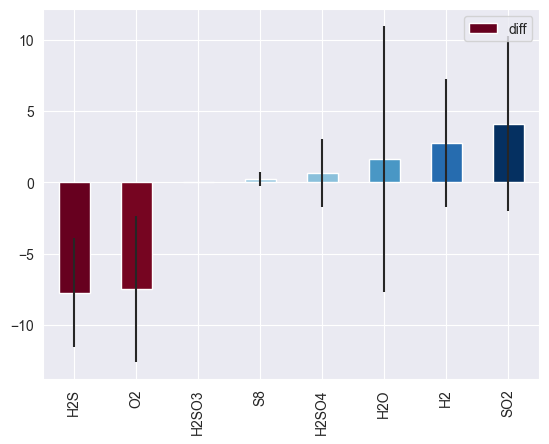

In [50]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

In [51]:
analysis.result_to_pyvis(data)

KeyError: 0

In [18]:
reaction,equilibrium_constant = data[1]['reaction_statistics'][1].values()
reaction,equilibrium_constant

({'reaction_string': '8 O2 + 1 S8 = 8 SO2',
  'reactants': {'O2': 8, 'S8': 1},
  'products': {'SO2': 8}},
 inf)

In [42]:
reaction_statistics = pd.Series(
    analysis.reaction_statistics(data)
    ).head(10).sort_values(ascending=False).to_dict()

pd.Series(reaction_statistics)

3 H2 + 1 SO2 = 2 H2O + 1 H2S      40
1 H2O + 1 SO2 = 1 H2SO3           38
1 H2 + 1 SO2 = 1 O2 + 1 H2S       35
3 O2 + 2 H2S = 2 H2O + 2 SO2      20
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2    16
2 H2 + 1 O2 = 2 H2O                9
8 O2 + 1 S8 = 8 SO2                8
2 O2 + 1 H2S = 1 H2SO4             4
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4      4
4 O2 + 8 H2S = 8 H2O + 1 S8        4
dtype: int64

In [33]:
for i,(reaction,reaction_dict) in enumerate(reaction_data.items()):
    reaction,k = reaction_dict.values() 
    print(k)

1.9121656308651555e-58
8.651565385080484e+34
inf
4.5244853507621374e+92
5.768443325304716e+136
1.1030219070241502e+79
1.2374229615727168e+208
3.8018398004920577e-06
41018998099206.35
0.0


In [26]:
import networkx as nx 
from pyvis.network import Network 
import numpy as np 


reaction_statistics = pd.Series(
    analysis.reaction_statistics(data)
    ).head(10).sort_values(ascending=False).to_dict()

rs = {}
nodes = [graph.nodes()[x] for x in graph.nodes() if isinstance(x,int)]
for i,node in enumerate(nodes):
    if node['reaction']['reaction_string'] in list(reaction_statistics):
        rs[i] = node['reaction'] 
        rs[i]['frequency'] = reaction_statistics[node['reaction']['reaction_string']]
        rs[i]['equilibrium_constant'] = node['equilibrium_constant']
        


G = nx.MultiDiGraph(directed=True)

for i,reaction in rs.items():
    if reaction['equilibrium_constant'] < 1:

        G.add_weighted_edges_from(
                [compound,str(i),1] for compound in reaction['products']
                ) #products -> reaction
        G.add_weighted_edges_from(
                [str(i),compound,1] for compound in reaction['reactants']
                ) #reaction -> products
    else:
        G.add_weighted_edges_from(
                [compound,str(i),1] for compound in reaction['reactants']
                ) #products -> reaction
        G.add_weighted_edges_from(
                [str(i),compound,1] for compound in reaction['products']
                ) #reaction -> products

compound_nodes = []
reaction_nodes = []
for node in G.nodes():
    try:
        int(node)
        reaction_nodes.append(node)
    except Exception:
        compound_nodes.append(node)


            
reaction_node_sizes = {str(i):8  for i,reaction in rs.items()} #reaction['frequency']
nx.set_node_attributes(G,reaction_node_sizes,name='size')



#set reaction node colour based on frequency
import numpy as np
import matplotlib as mpl

frequency = pd.Series({str(i):reaction['frequency']  for i,reaction in rs.items()}) #
cmap = mpl.colormaps['Reds']
norm = mpl.colors.Normalize(vmin=frequency.min(),vmax=frequency.max())
colours = {str(r):mpl.colors.rgb2hex(cmap(norm(freq))) for r,freq in frequency.items()}
nx.set_node_attributes(G,colours,name='color')

compound_node_colours = {node:'grey' for node in compound_nodes}
nx.set_node_attributes(G,compound_node_colours,name='color')

#set up pyvis graph
g = Network(height='750%',width='100%',notebook=False,directed=True,font_color="white",neighborhood_highlight=True)

g.repulsion(
    node_distance=100,
    spring_length=50,
    damping=0.01,
)
g.from_nx(G,edge_scaling=False)


#assign reactions to tooltips 

for reaction in reaction_nodes:
    g.node_map[reaction]['shape'] = 'circle'
    g.node_map[reaction]['title'] = '{} ; frequency = {}'.format(
        rs[int(reaction)]['reaction_string'],rs[int(reaction)]['frequency']
    )
    g.node_map[reaction]['label'] = None

for compound in compound_nodes:
    g.node_map[compound]['shape'] = 'box'

g.barnes_hut()

g.save_graph('graph.html')

In [294]:
g.node_map['H2SO4']

{'color': 'grey', 'size': 10, 'id': 'H2SO4', 'label': 'H2SO4', 'shape': 'dot'}

In [290]:
net = Network()
net.add_nodes([1,2,3], value=[10, 100, 400],
                         title=['I am node 1', 'node 2 here', 'and im node 3'],
                         x=[21.4, 54.2, 11.2],
                         y=[100.2, 23.54, 32.1],
                         label=['NODE 1', 'NODE 2', 'NODE 3'],
                         color=['#00ff1e', '#162347', '#dd4b39'])

for node in net.get_nodes():
    print(node)

net.node_map

1
2
3


{1: {'color': '#00ff1e',
  'value': 10,
  'title': 'I am node 1',
  'x': 21.4,
  'y': 100.2,
  'id': 1,
  'label': 'NODE 1',
  'shape': 'dot'},
 2: {'color': '#162347',
  'value': 100,
  'title': 'node 2 here',
  'x': 54.2,
  'y': 23.54,
  'id': 2,
  'label': 'NODE 2',
  'shape': 'dot'},
 3: {'color': '#dd4b39',
  'value': 400,
  'title': 'and im node 3',
  'x': 11.2,
  'y': 32.1,
  'id': 3,
  'label': 'NODE 3',
  'shape': 'dot'}}

In [237]:
g.get_edges()[2]

{'width': 1, 'from': 'H2SO3', 'to': '438', 'arrows': 'to', 'color': 'grey'}

In [161]:
G.nodes['8']

{'size': 0, 'color': 'red'}

In [157]:
df = pd.Series(frequency)
normalized_df=(df-df.min())/(df.max()-df.min())

normalized_df

8       0.594315
11      0.020672
13      0.031008
18      0.000000
19      0.695090
20      0.175711
25      0.000000
30      0.124031
32      0.010336
38      0.093023
62      0.328165
67      0.010336
104     0.010336
131     0.142119
146     0.000000
160     0.010336
175     0.000000
184     0.118863
222     0.183463
226     0.020672
252     0.020672
294     0.041344
295     0.010336
300     0.173127
306     0.010336
310     0.031008
320     0.007752
329     0.121447
344     0.000000
351     0.266150
354     0.069767
384     0.000000
401     1.000000
402     0.020672
405     0.000000
438     0.072351
455     0.307494
469     0.000000
471     0.056848
801     0.000000
1390    0.000000
1833    0.082687
1860    0.142119
2653    0.000000
2682    0.020672
2940    0.000000
3162    0.155039
3348    0.214470
3511    0.000000
3652    0.000000
3679    0.000000
4053    0.010336
4102    0.062016
4697    0.000000
4710    0.000000
4855    0.051680
4858    0.051680
4965    0.010336
5097    0.0413

In [153]:
G.nodes()['8']

{'size': 234}

effect of adding NO2

In [111]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

t.rank_by_number_of_atoms = True

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)#,tqdm_kws={'disable':True})

In [112]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling() #use_markdown=True,use_latex=True)
print(pd.Series(analysis.count_path_length(data)))
pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False).head(10)

5    191
4    228
3    270
2    242
6     36
1     32
dtype: int64


1 H2 + 1 SO2 = 1 O2 + 1 H2S              391
2 H2 + 1 O2 = 2 H2O                      273
1 H2O + 1 SO2 = 1 H2SO3                  234
1 H2O + 1 NO2 + 1 NO = 2 HNO2            131
3 H2 + 1 SO2 = 2 H2O + 1 H2S             123
3 O2 + 2 H2S = 2 H2O + 2 SO2             107
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO     87
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2           75
8 O2 + 1 S8 = 8 SO2                       72
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2            71
dtype: int64

In [113]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(2)
average_data.sort_values(by='diff',inplace=True)
average_data.round(1)

,initial,mean,diff,std
H2S,10.0,4.8,-5.2,4.7
NO2,10.0,5.9,-4.1,4.9
O2,10.0,6.2,-3.8,6.0
H2O,30.0,29.2,-0.8,6.1
S8,0.0,0.1,0.1,0.3
NH3,0.0,0.1,0.1,0.8
H2SO3,0.0,0.3,0.3,1.6
NOHSO4,0.0,0.3,0.3,1.2
HNO3,0.0,0.5,0.5,1.6
HNO2,0.0,0.6,0.6,1.9


<Axes: >

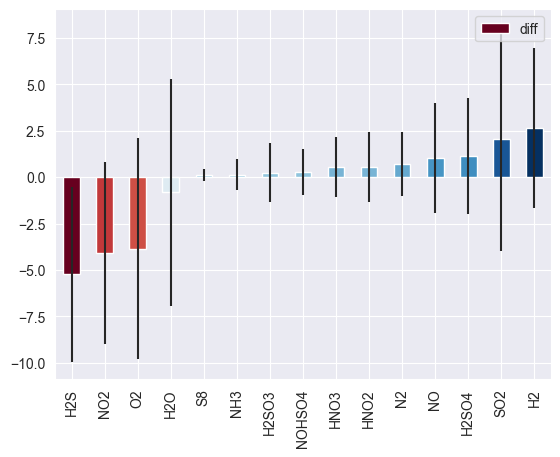

In [114]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

testing

In [107]:
import networkx as nx 
from pyvis.network import Network 


reaction_statistics = analysis.reaction_statistics(data)

rs = {}
reactions = [graph.nodes()[x]['reaction'] for x in graph.nodes() if isinstance(x,int)]
for i,reaction in enumerate(reactions):
    if reaction['reaction_string'] in list(reaction_statistics):
        rs[i] = reaction 
        rs[i]['frequency'] = reaction_statistics[reaction['reaction_string']]
        

G = nx.MultiDiGraph(directed=True)

for i,reaction in rs.items():
    G.add_weighted_edges_from(
                [compound,str(i),1] for compound in reaction['reactants']
                ) #reactants -> reaction
    G.add_weighted_edges_from(
                [str(i),compound,1] for compound in reaction['products']
                ) #reaction -> products
            
frequency = {str(i):reaction['frequency'] for i,reaction in rs.items()}

nx.set_node_attributes(G,frequency,name='frequency')

g = Network(height=800,width=800,notebook=False,directed=True,neighborhood_highlight=True)
g.from_nx(G,show_edge_weights=False)
g.save_graph('graph.html')

### Speed Test 

In [ ]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic({'H2O':100,'H2':30,'O2':50,'H2S':100,'NO2':200,'N2':300})
t = Traversal(graph=graph)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=1)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=2)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=4)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=10)

In [ ]:
t.random_walk(gic)